<a href="https://colab.research.google.com/github/AlexeyEvzrezov/deep-learning/blob/main/semantic_segmentation/semantic_segmentation_melanoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation of Skin Lesions

In [ ]:
import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
from time import time

from skimage.io import imread
from skimage.transform import resize
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams

from IPython.display import clear_output

rcParams['figure.figsize'] = (15,4)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Data Preparation

## Loading Data

In [ ]:
PATH = './content/data'

In [ ]:
get_ipython().system_raw("unrar x /content/PH2Dataset.rar")

In [ ]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True ) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


## Data Visualization

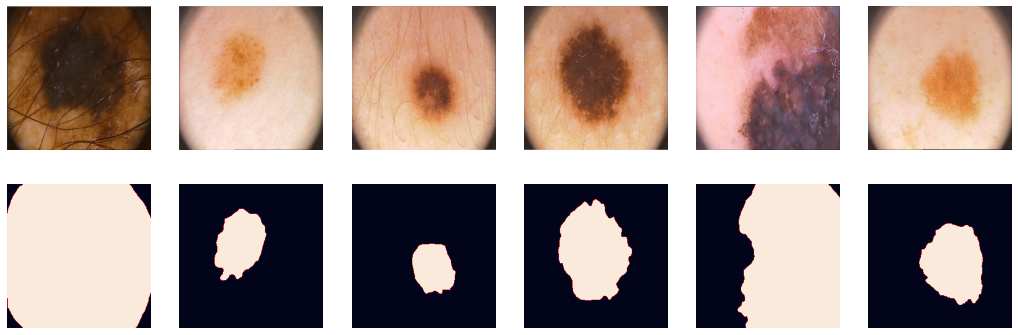

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

## Train Test Split

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


# PyTorch DataLoader

In [ ]:
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

# SegNet Implementation  
Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). SegNet: A deep convolutional encoder-decoder architecture for image segmentation

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()            
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()            
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),     
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()                             
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),  
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()                             
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),     
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, return_indices=True) # 16 -> 8   
        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2) # 8 -> 16 
        self.bottleneck_dec_conv = nn.Sequential(  
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512), 
            nn.ReLU(), 
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU()                    
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),  
            nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()                             
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),     
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )     
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()            
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, ids0 = self.pool0(self.enc_conv0(x))
        e1, ids1 = self.pool1(self.enc_conv1(e0))
        e2, ids2 = self.pool2(self.enc_conv2(e1))
        e3, ids3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b_e, ids_b_e = self.bottleneck_pool(self.bottleneck_conv(e3))
        b_d = self.bottleneck_dec_conv(self.bottleneck_upsample(b_e, ids_b_e))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b_d, ids3))
        d1 = self.dec_conv1(self.upsample1(d0, ids2))
        d2 = self.dec_conv2(self.upsample2(d1, ids1))
        d3 = self.dec_conv3(self.upsample3(d2, ids0)) # no activation
        return d3

# IoU Scoring Metric  
(taken from [https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy](https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy))


In [ ]:
def iou_pytorch(labels: torch.Tensor, outputs: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10 ).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean() # Or thresholded.mean() if you are interested in average across the batch

# BCE Loss Implementation



$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$



$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(labels: torch.Tensor, outputs: torch.Tensor):
    loss = outputs * (1 - labels) + torch.log(1 + torch.exp(-outputs))
    return torch.mean(loss)

# Train and Visualization Functions

In [ ]:
def fit_epoch(model, opt, loss_fn, data_tr):
    avg_loss = .0
    avg_iou = .0

    model.train()
  
    for inputs, labels in data_tr:
        inputs = inputs.to(device)
        labels = labels.to(device)
        opt.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(labels, outputs)
        loss.backward()
        opt.step()

        avg_loss += loss.item() / len(data_tr)
        avg_iou += iou_pytorch(
            labels, outputs > .5).mean().item() / len(data_tr)

    return avg_loss, avg_iou

In [ ]:
def eval_epoch(model, loss_fn, data_val):
    
    avg_loss = .0
    avg_iou = .0

    model.eval()

    for inputs, labels in data_val:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = loss_fn(labels, outputs)

        avg_loss += loss.item() / len(data_val)
        avg_iou += iou_pytorch(
            labels, outputs > .5).mean().item() / len(data_val)

    return avg_loss, avg_iou

In [ ]:
def train(model, opt, loss_fn, data_tr, data_val, epochs):
    X_val, Y_val = next(iter(data_val))
    history = []

    for epoch in range(epochs):
        print(f'* Epoch {epoch + 1}/{epochs}')  
        avg_loss_tr, avg_iou_tr = fit_epoch(model, opt, loss_fn, data_tr)
        avg_loss_val, avg_iou_val = eval_epoch(model, loss_fn, data_val)
        history.append((avg_loss_tr, avg_iou_tr, avg_loss_val, avg_iou_val))

        # Visualization
        model.eval()  # testing mode        
        Y_hat = model(X_val.to(device)).detach().cpu()               
        clear_output(wait=True)
        fig = plt.figure(figsize=(19, 5))
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray') 
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0] > .5, cmap='gray') 
            plt.title('Output (bin)')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Target Mask')
            plt.axis('off')

        plt.suptitle('%d / %d - loss train/val: %f / %f' % (
            epoch + 1, epochs, avg_loss_tr, avg_loss_val))
        plt.show()

        loss_tr, iou_tr, loss_val, iou_val = zip(*history)

        fig = plt.figure(figsize=(17.2, 5))

        plt.subplot(1, 2, 1)  
        plt.title('Loss') 
        plt.xlabel('epoch')
        plt.plot(loss_tr, label='train_loss')
        plt.plot(loss_val, label='val_loss')
        plt.legend()           

        plt.subplot(1, 2, 2)
        plt.title('IoU')
        plt.xlabel('epoch')
        plt.plot(iou_tr, label='train_IoU')
        plt.plot(iou_val, label='val_IoU') 
        plt.legend() 
        plt.show()
          
    return history

# Inference and Scoring Functions

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch.to(device)) for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)      
        with torch.set_grad_enabled(False):
            Y_pred = model(X_batch) 
            score = metric((Y_pred > .5), Y_label).mean().item()
        scores += score

    return scores/len(data)

# Learning. BCE Loss with SegNet

In [ ]:
model = SegNet().to(device)

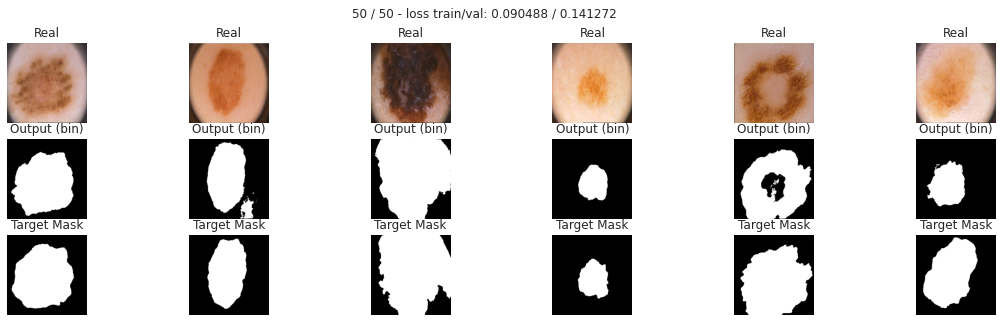

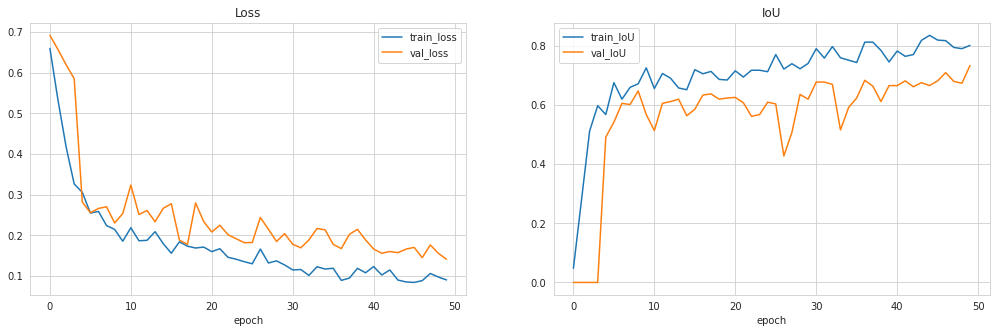

In [ ]:
max_epochs = 50
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
segnet_bce_history = train(model, optim, bce_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.734000027179718

# Dice Loss Implementation

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$



$$\mathcal L_D(X,Y) = 1-\sum_i\frac{2X_iY_i}{X_i+Y_i}.$$




In [ ]:
def dice_loss(labels: torch.Tensor, outputs: torch.Tensor):
    SMOOTH = 1e-8
    outputs = torch.clamp(outputs, SMOOTH, 1 - SMOOTH) 
    num = 2. * (labels * outputs).sum((1, 2, 3))
    den = (labels + outputs).sum((1, 2, 3))
    res = 1 - torch.mean((num + SMOOTH) / (den + SMOOTH))
    return res

# Learning. Dice Loss with SegNet

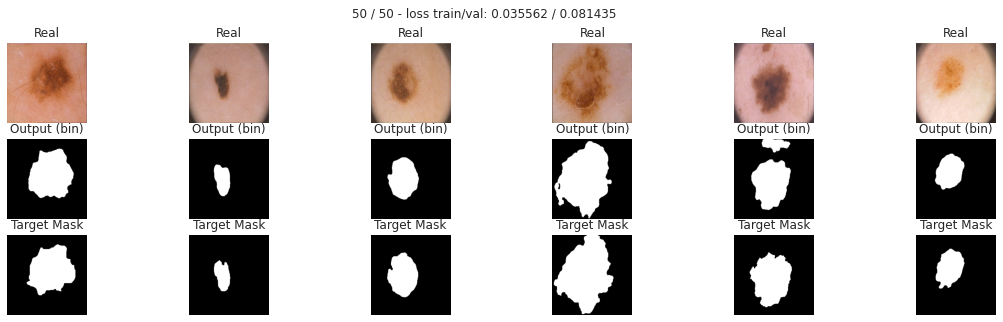

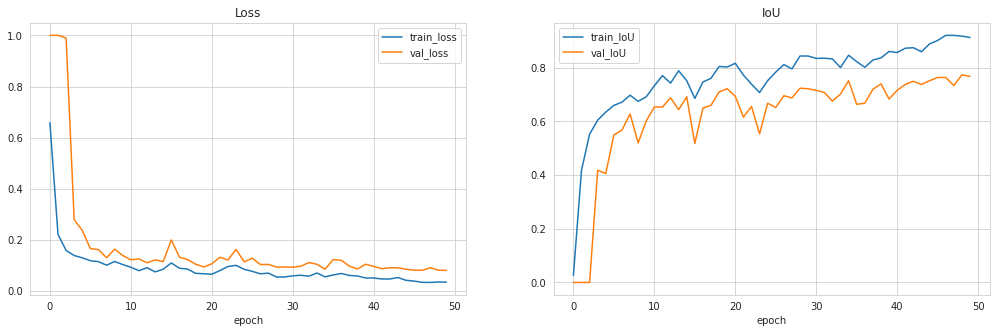

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 50
optim_dice = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
segnet_dice_history = train(
    model_dice, optim_dice, dice_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7680000424385071

# Focal Loss Implementation



$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right]$$


$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right]$$



$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right]$$





In [ ]:
def focal_loss(labels: torch.Tensor, outputs: torch.Tensor, eps=1e-8, gamma=2):
    outputs = torch.clamp(outputs, eps, 1 - eps)
    bce = bce_loss(labels, outputs)
    f_loss = (1 - torch.exp(-bce)) ** gamma * bce
    return f_loss 

# Learning. Focal Loss with SegNet

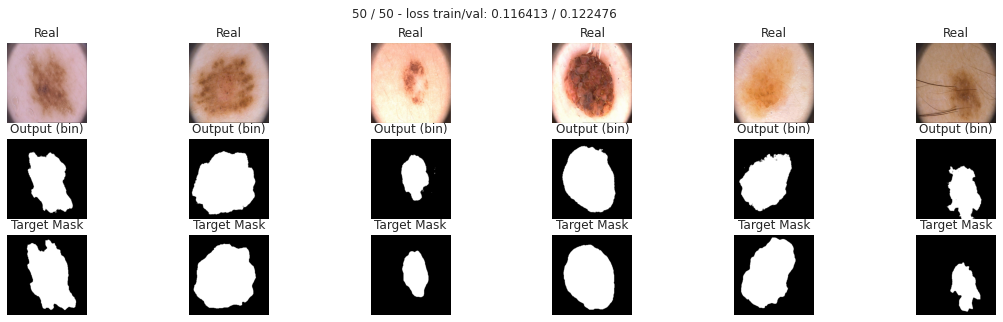

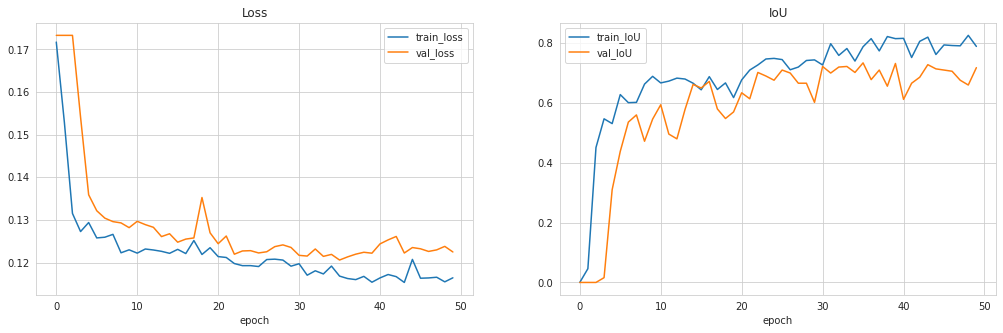

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 50
optim_focal = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
segnet_focal_history = train(
    model_focal, optim_focal, focal_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.7180000066757202

# Lovasz-Softmax Loss Implementation

In [ ]:
def lovasz_loss(labels: torch.Tensor, outputs: torch.Tensor):
    labels = labels.view(-1)
    outputs = outputs.view(-1)  
    signs = 2. * labels.float() - 1.
    errors = (1. - outputs * signs)
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    gt = labels[perm.data]
    gts = gt.sum()
    intersection = gts - gt.float().cumsum(0)
    union = gts + (1 - gt).float().cumsum(0)
    grad = 1. - intersection / union
    loss = torch.dot(F.elu(errors_sorted) + 1, grad) 
    return loss

# Learning. Lovasz-Softmax Loss with SegNet

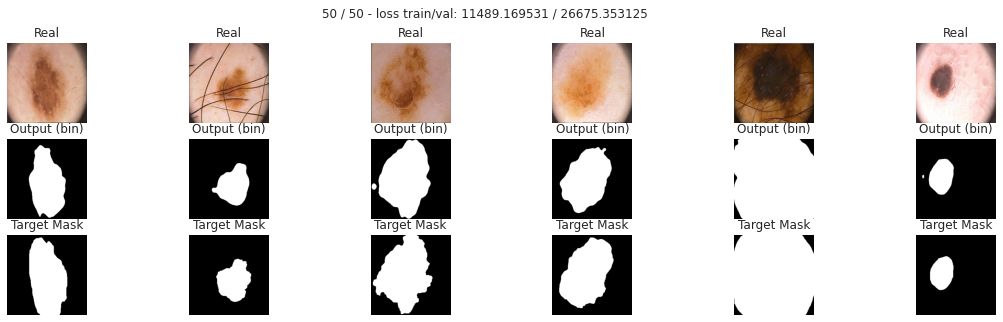

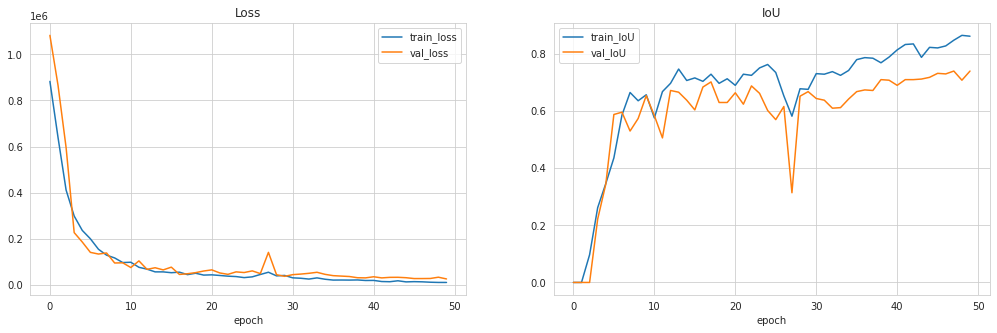

In [ ]:
model_lovasz = SegNet().to(device)

max_epochs = 50
optim_lovasz = torch.optim.Adam(model_lovasz.parameters(), lr=1e-4)
segnet_lovasz_history = train(
    model_lovasz, optim_lovasz, lovasz_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(model_lovasz, iou_pytorch, data_val)

0.7400000333786011

# U-Net Implementation  
Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-Net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
           
        self.enc_conv1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2), # 256 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.enc_conv2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2), # 128 -> 64
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2), # 64 -> 32
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2), # 32 -> 16
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(  
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU()                   
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(  
            nn.Conv2d(512, 256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU()                   
        )
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(  
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU()                   
        )
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(  
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1, padding=0)                   
        )

    def concat(self, x1, x2):        
        diffX = x2.shape[3] - x1.shape[3]
        diffY = x2.shape[2] - x1.shape[2]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])        
        return torch.cat([x2, x1], dim=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.concat(self.upsample0(b), e3)) 
        d1 = self.dec_conv1(self.concat(self.upsample0(d0), e2)) 
        d2 = self.dec_conv2(self.concat(self.upsample0(d1), e1))
        d3 = self.dec_conv3(self.concat(self.upsample0(d2), e0)) # no activation

        return d3
        # working

## BCE Loss with U-Net

In [ ]:
unet_model = UNet().to(device)

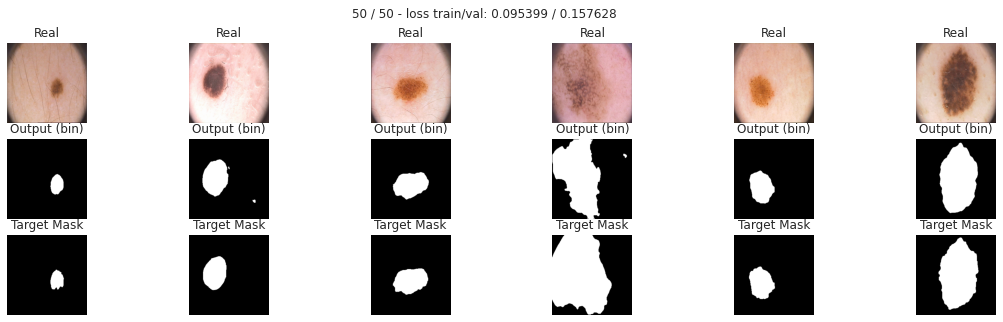

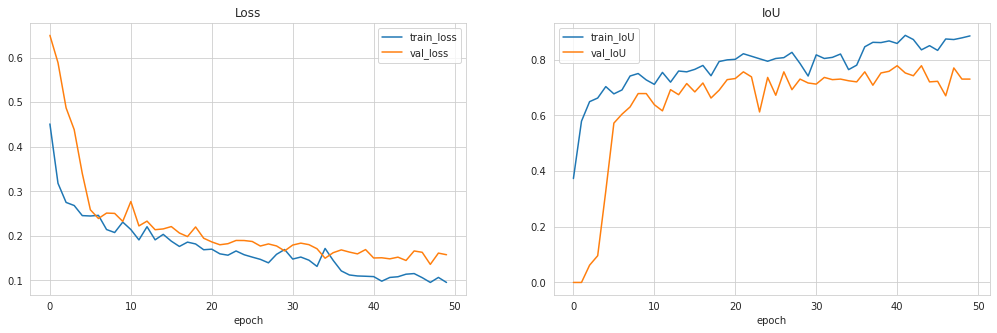

In [ ]:
max_epochs = 50
optim_bce_unet = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
unet_bce_history = train(
    unet_model, optim_bce_unet, bce_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7300000429153443

## Dice Loss with U-Net

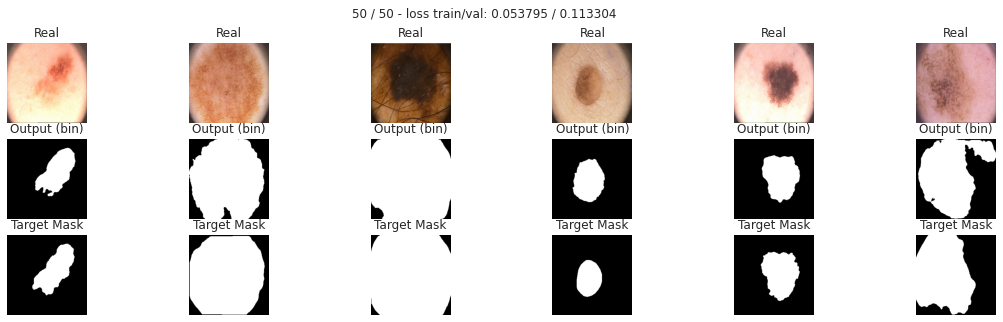

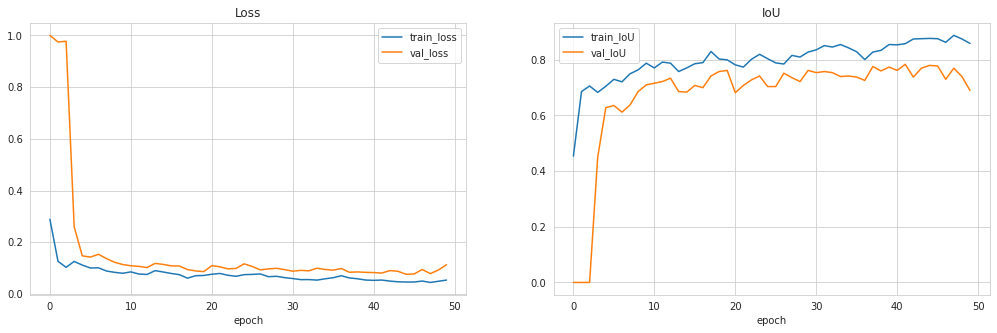

In [ ]:
unet_dice = UNet().to(device)

max_epochs = 50
optim_dice_unet = torch.optim.Adam(unet_dice.parameters(), lr=1e-4)
unet_dice_history = train(
    unet_dice, optim_dice_unet, dice_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(unet_dice, iou_pytorch, data_val)

0.6900000214576721

## Focal Loss  with U-Net

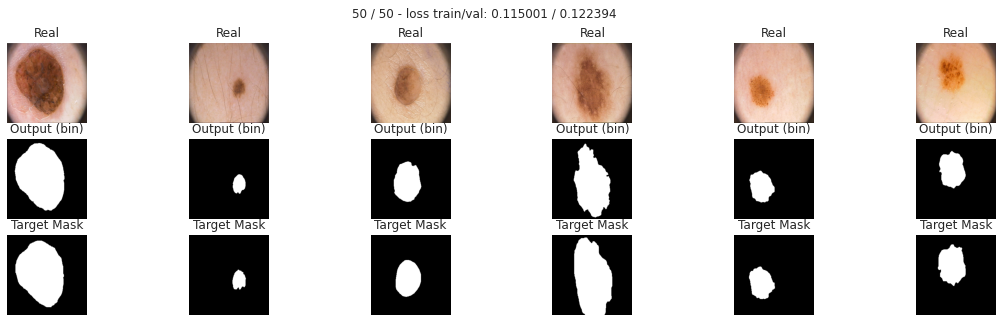

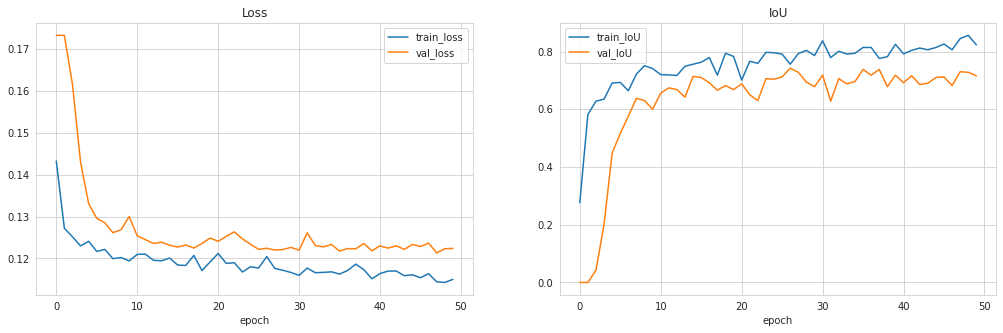

In [ ]:
unet_focal = UNet().to(device)

max_epochs = 50
optim_focal_unet = torch.optim.Adam(unet_focal.parameters(), lr=1e-4)
unet_focal_history = train(
    unet_focal, optim_focal_unet, focal_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(unet_focal, iou_pytorch, data_val)

0.7160000324249267

## Lovasz-Softmax Loss with U-Net

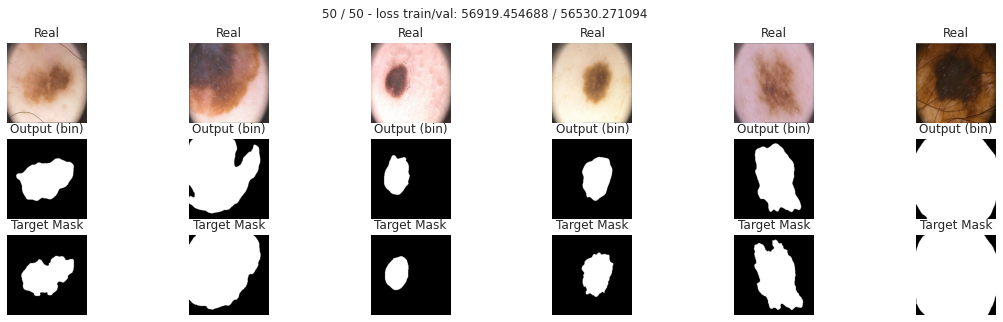

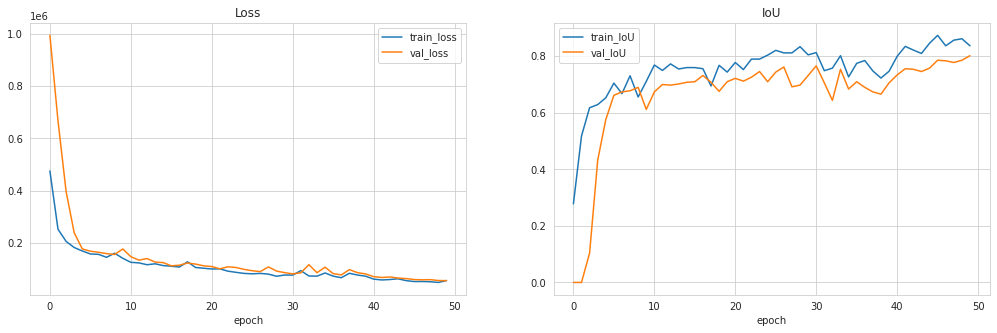

In [ ]:
unet_lovasz = UNet().to(device)

max_epochs = 50
optim_lovasz_unet = torch.optim.Adam(unet_lovasz.parameters(), lr=1e-4)
unet_lovasz_history = train(
    unet_lovasz, optim_lovasz_unet, lovasz_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(unet_lovasz, iou_pytorch, data_val)

0.8020000576972961

# U-Net 2 Implementation

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
           
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), # 256 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), # 128 -> 64
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), # 64 -> 32
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1), # 32 -> 16
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1) # 16 -> 32
        self.dec_conv0 = nn.Sequential(  
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU()                   
        )
        self.upsample1 = nn.ConvTranspose2d(256, 256, 3, stride=2, padding=1) # 32 -> 64
        self.dec_conv1 = nn.Sequential(  
            nn.Conv2d(512, 256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU()                   
        )
        self.upsample2 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(  
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU()                   
        )
        self.upsample3 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(  
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1, padding=0)                   
        )

    def concat(self, x1, x2):        
        diffX = x2.shape[3] - x1.shape[3]
        diffY = x2.shape[2] - x1.shape[2]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])        
        return torch.cat([x2, x1], dim=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.concat(self.upsample0(b), e3)) 
        d1 = self.dec_conv1(self.concat(self.upsample1(d0), e2)) 
        d2 = self.dec_conv2(self.concat(self.upsample2(d1), e1))
        d3 = self.dec_conv3(self.concat(self.upsample3(d2), e0)) # no activation

        return d3   

## BCE Loss with U-Net 2 

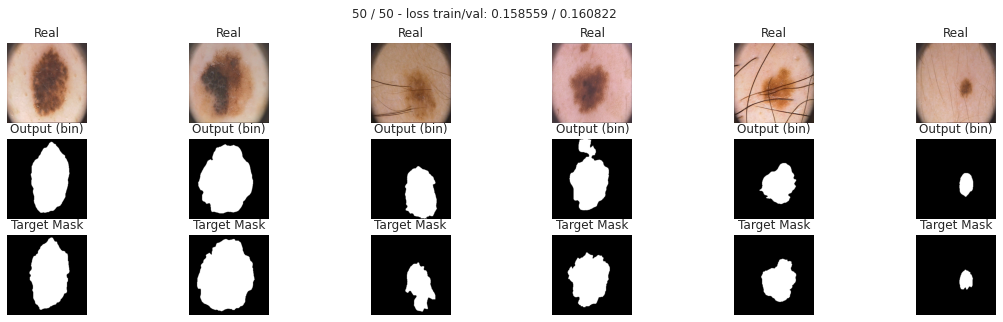

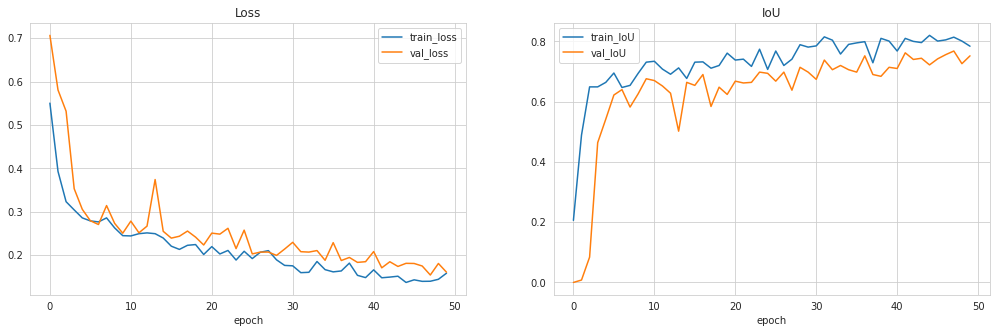

In [ ]:
unet2_model = UNet2().to(device)

max_epochs = 50
optim_bce_unet2 = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)
unet2_bce_history = train(
    unet2_model, optim_bce_unet2, bce_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.7519999980926514

## Dice Loss with U-Net 2 

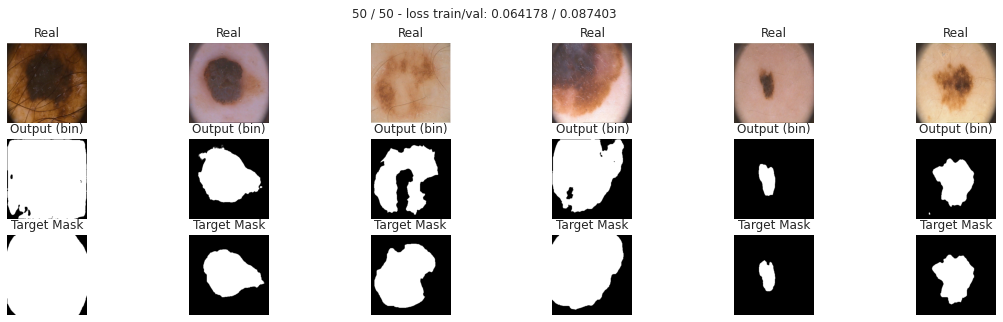

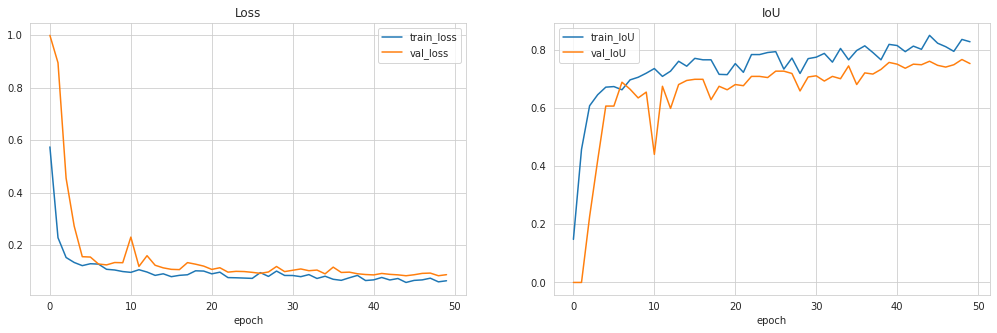

In [ ]:
unet2_dice = UNet2().to(device)

max_epochs = 50
optim_dice_unet2 = torch.optim.Adam(unet2_dice.parameters(), lr=1e-4)
unet2_dice_history = train(
    unet2_dice, optim_dice_unet2, dice_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(unet2_dice, iou_pytorch, data_val)

0.7520000338554382

## Focal Loss with U-Net 2 

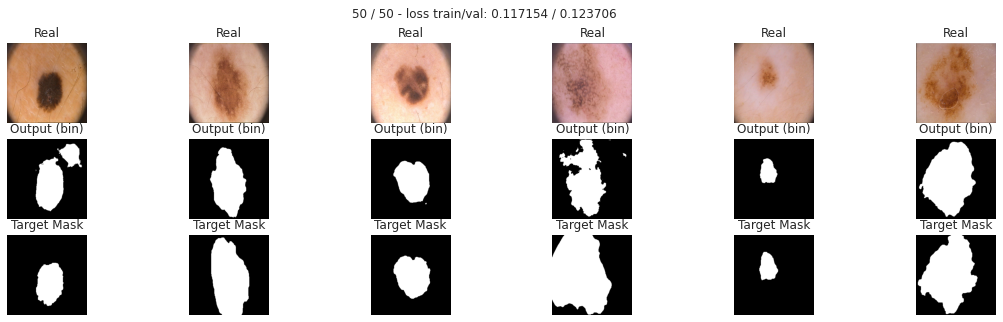

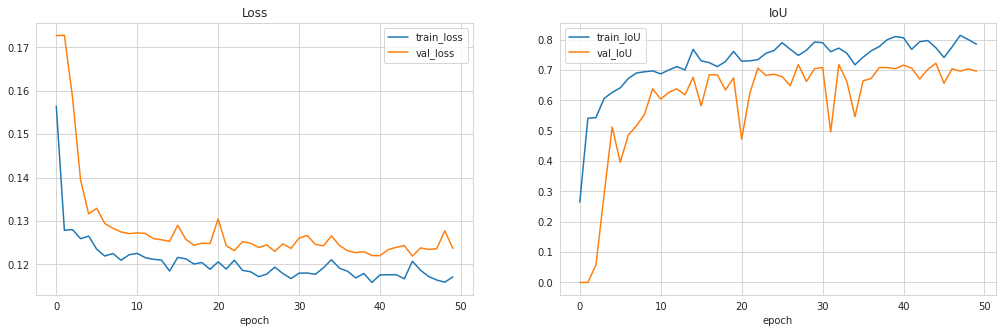

In [ ]:
unet2_focal = UNet2().to(device)

max_epochs = 50
optim_focal_unet2 = torch.optim.Adam(unet2_focal.parameters(), lr=1e-4)
unet2_focal_history = train(
    unet2_focal, optim_focal_unet2, focal_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(unet2_focal, iou_pytorch, data_val)

0.74000004529953

## Lovasz-Softmax Loss with U-Net 2 

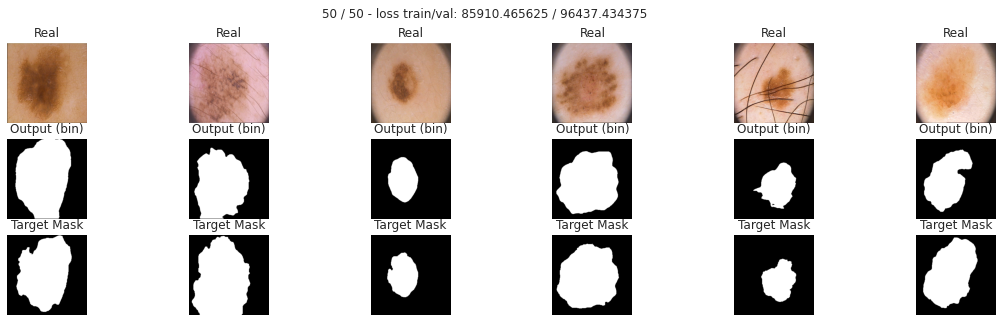

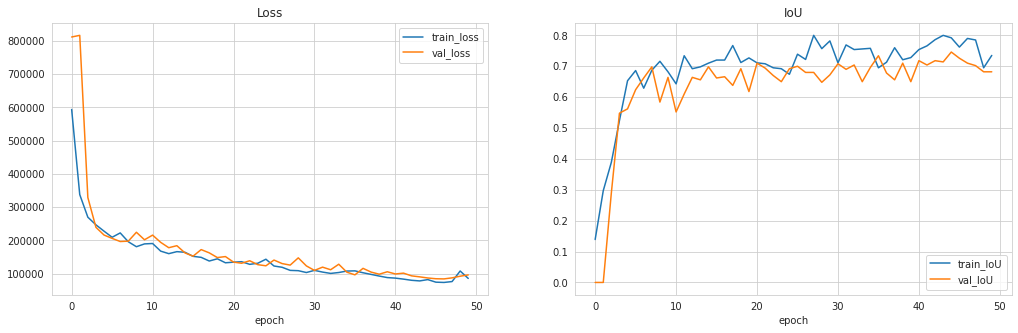

In [ ]:
unet2_lovasz = UNet2().to(device)

max_epochs = 50
optim_lovasz_unet2 = torch.optim.Adam(unet2_lovasz.parameters(), lr=1e-4)
unet2_lovasz_history = train(
    unet2_lovasz, optim_lovasz_unet2, lovasz_loss, data_tr, data_val, max_epochs)

In [ ]:
score_model(unet2_lovasz, iou_pytorch, data_val)

0.6820000290870667

# Models/Losses Comparison

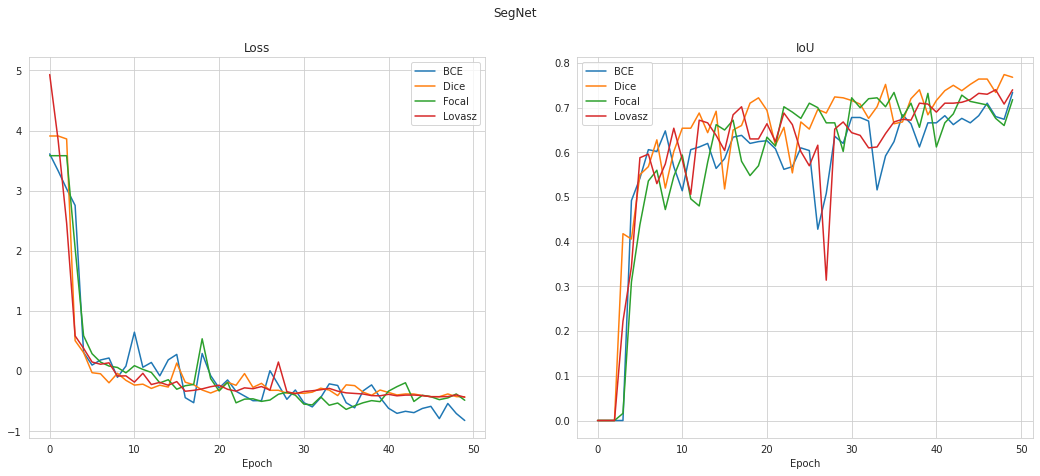

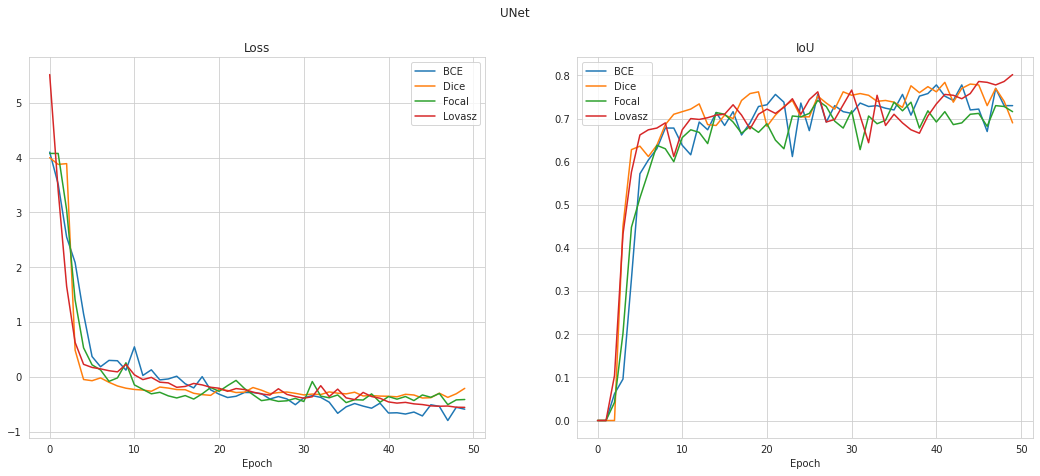

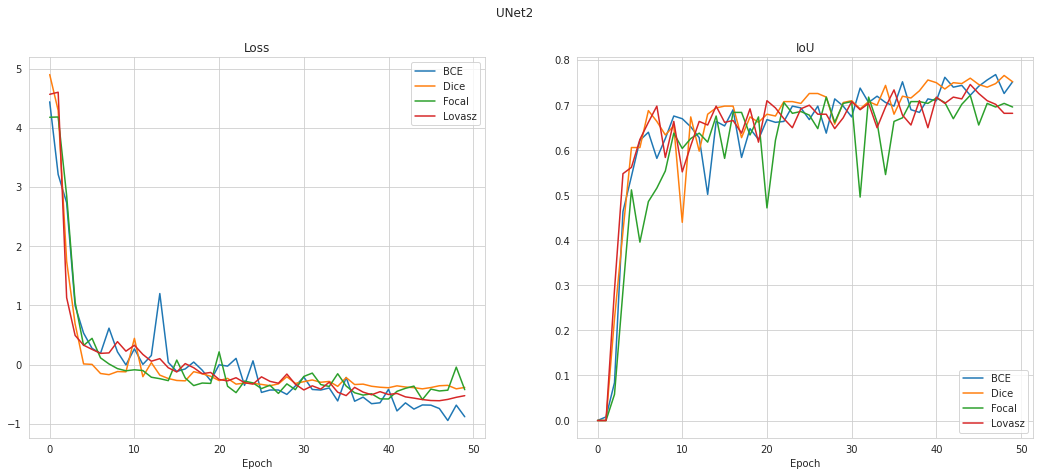